In [40]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib



df = pd.read_excel('./online+retail/Online Retail.xlsx')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

features = df[['InvoiceNo', 'Quantity', 'UnitPrice', 'Country']].copy()

features[['Quantity', 'UnitPrice']] = features[['Quantity', 'UnitPrice']].apply(pd.to_numeric, errors='coerce')
features['InvoiceNo'] = pd.to_numeric(features['InvoiceNo'], errors='coerce')

features.dropna(subset=['InvoiceNo', 'Quantity', 'UnitPrice', 'Country'], inplace=True)
features = features[(features['Quantity'] > 0) & (features['UnitPrice'] > 0)]
features['InvoiceNo'] = features['InvoiceNo'].astype(int)
features['Total'] = features['Quantity'] * features['UnitPrice']
invoice_freq = features['InvoiceNo'].value_counts()
features['Frequency'] = features['InvoiceNo'].map(invoice_freq)

print(features.head())

   InvoiceNo  Quantity  UnitPrice         Country  Total  Frequency
0     536365         6       2.55  United Kingdom  15.30          7
1     536365         6       3.39  United Kingdom  20.34          7
2     536365         8       2.75  United Kingdom  22.00          7
3     536365         6       3.39  United Kingdom  20.34          7
4     536365         6       3.39  United Kingdom  20.34          7


In [41]:
X = features[['Total', 'Frequency','Quantity', 'UnitPrice']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

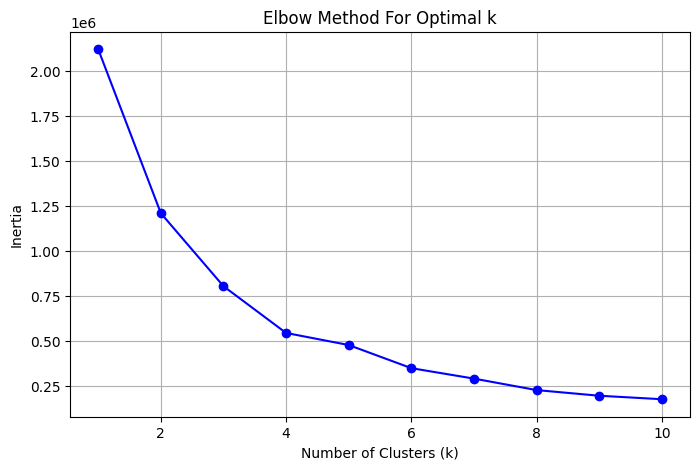

In [42]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

             Total  Frequency  Quantity  UnitPrice
Cluster                                           
0             9.88     489.79      2.85       5.21
1        122826.60       1.00  77605.00       1.56
2            20.71      62.03     11.22       3.51
3          2790.63     161.83      1.00    2790.63


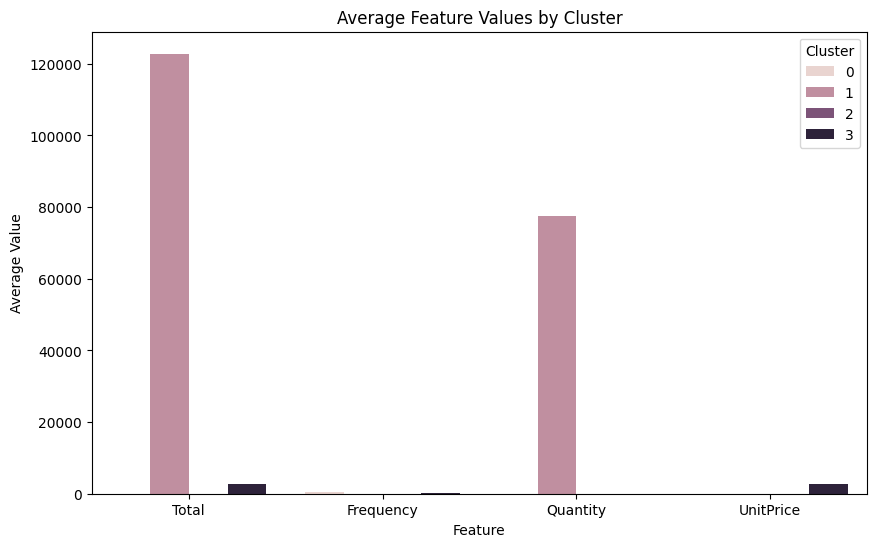

In [43]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
features['Cluster'] =kmeans.labels_

cluster_summary = features.groupby('Cluster')[['Total', 'Frequency','Quantity', 'UnitPrice']].mean().round(2)
print(cluster_summary)

cluster_summary = cluster_summary.reset_index()
melted = pd.melt(cluster_summary, id_vars='Cluster', var_name='Feature', value_name='Average')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Feature', y='Average', hue='Cluster')
plt.title('Average Feature Values by Cluster')
plt.xlabel('Feature')
plt.ylabel('Average Value')
plt.legend(title='Cluster')
plt.show()




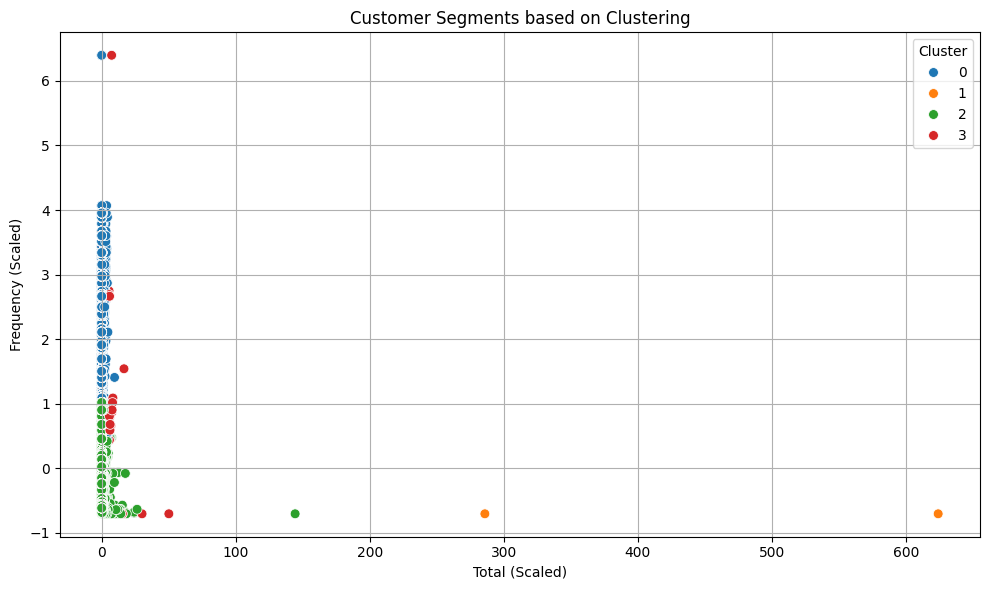


Sample from each Cluster:

Frequent Low-Spenders:
           Total  Frequency         Country
15017   13541.33          1  United Kingdom
117054   1687.17          1            EIRE
117055   1687.17          1            EIRE

High-Value Repeat Buyers:
      Total  Frequency         Country
1443   2.51        527  United Kingdom
1444   5.02        527  United Kingdom
1445   3.40        527  United Kingdom

Low-Value Occasional Buyers:
   Total  Frequency         Country
0  15.30          7  United Kingdom
1  20.34          7  United Kingdom
2  22.00          7  United Kingdom

One-Time Medium Buyers:
           Total  Frequency         Country
61619    77183.6          1  United Kingdom
540421  168469.6          1  United Kingdom


In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=features['Cluster'], palette='tab10', s=50)
plt.title('Customer Segments based on Clustering')
plt.xlabel('Total (Scaled)')
plt.ylabel('Frequency (Scaled)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

cluster_labels = {
  0: "High-Value Repeat Buyers",
  1: "One-Time Medium Buyers",
  2: "Low-Value Occasional Buyers",
  3: "Frequent Low-Spenders"
}
features['Cluster_Label'] = features['Cluster'].map(cluster_labels)

print("\nSample from each Cluster:")
for label, group in features.groupby('Cluster_Label'):
  print(f"\n{label}:")
  print(group[['Total', 'Frequency', 'Country']].head(3))

In [45]:
# outliers
print(features[features['Cluster'] == 1])
print(features[features['Cluster'] == 3])

        InvoiceNo  Quantity  UnitPrice         Country     Total  Frequency  \
61619      541431     74215       1.04  United Kingdom   77183.6          1   
540421     581483     80995       2.08  United Kingdom  168469.6          1   

        Cluster           Cluster_Label  
61619         1  One-Time Medium Buyers  
540421        1  One-Time Medium Buyers  
        InvoiceNo  Quantity  UnitPrice         Country     Total  Frequency  \
15017      537632         1   13541.33  United Kingdom  13541.33          1   
117054     546328         1    1687.17            EIRE   1687.17          1   
117055     546329         1    1687.17            EIRE   1687.17          1   
119632     546558         1    2583.76       Hong Kong   2583.76          1   
144826     548813         1    2382.92       Singapore   2382.92          4   
144829     548820         1    2053.07       Singapore   2053.07          1   
150615     549468         1    1867.86  United Kingdom   1867.86          1   
1733

In [46]:
print("clusters:", features['Cluster'].value_counts())

print('first 50 rows:')
print(features[['InvoiceNo', 'Quantity', 'UnitPrice', 'Total', 'Frequency', 'Cluster']].head(50))

print("clusters:", features['Cluster'].value_counts())

clusters: Cluster
2    468567
0     61499
3        35
1         2
Name: count, dtype: int64
first 50 rows:
    InvoiceNo  Quantity  UnitPrice   Total  Frequency  Cluster
0      536365         6       2.55   15.30          7        2
1      536365         6       3.39   20.34          7        2
2      536365         8       2.75   22.00          7        2
3      536365         6       3.39   20.34          7        2
4      536365         6       3.39   20.34          7        2
5      536365         2       7.65   15.30          7        2
6      536365         6       4.25   25.50          7        2
7      536366         6       1.85   11.10          2        2
8      536366         6       1.85   11.10          2        2
9      536367        32       1.69   54.08         12        2
10     536367         6       2.10   12.60         12        2
11     536367         6       2.10   12.60         12        2
12     536367         8       3.75   30.00         12        2
13     5363

In [47]:
print("Clusters in first 50 rows:")
print(features.head(50)['Cluster'].value_counts())
print('---------------------')
print("Clusters in full dataset:")
print(features['Cluster'].value_counts())


Clusters in first 50 rows:
Cluster
2    50
Name: count, dtype: int64
---------------------
Clusters in full dataset:
Cluster
2    468567
0     61499
3        35
1         2
Name: count, dtype: int64


In [48]:
# Save the trained KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']